IMPORT Libarrays 

In [2]:
import pandas as pd
import numpy as np

In [3]:
import os

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [6]:
from bs4 import BeautifulSoup
import requests

Import dataset from kaggle or local file

In [7]:
directory = '1_movies_per_genre'

files = os.listdir(directory)

for file in files:
    print(file)

Action.csv
Adventure.csv
Animation.csv
Biography.csv
Comedy.csv
Crime.csv
Drama.csv
Fantasy.csv
History.csv
Horror.csv
Music.csv
Mystery.csv
Romance.csv
Sci-Fi.csv
Sport.csv
Thriller.csv
War.csv


Marge all dataset file into one single dataset

In [8]:

directory = '1_movies_per_genre'
main_dataset = pd.DataFrame()

files = os.listdir(directory)

for file in files:
    file_path = os.path.join(directory, file)
    dataset = pd.read_csv(file_path)
    main_dataset = pd.concat([main_dataset, dataset], ignore_index=True)

print(main_dataset)

                                                   name  year movie_rated  \
0                                       The Dark Knight  2008       PG-13   
1                                             Inception  2010       PG-13   
2                                            The Matrix  1999           R   
3     The Lord of the Rings: The Fellowship of the Ring  2001       PG-13   
4                                 The Dark Knight Rises  2012       PG-13   
...                                                 ...   ...         ...   
1695                                           Catch-22  1970           R   
1696                                     The Great Raid  2005           R   
1697                                Saints and Soldiers  2003       PG-13   
1698                                          Stop-Loss  2008           R   
1699                                          The Alamo  2004       PG-13   

     run_length                       genres            release_date  ratin

In [9]:
main_dataset.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews,review_url
0,The Dark Knight,2008,PG-13,2h 32min,Action; Crime; Drama;,18 July 2008 (USA),9.0,2224522,6836,https://www.imdb.com/title/tt0468569/reviews/_...
1,Inception,2010,PG-13,2h 28min,Action; Adventure; Sci-Fi;,16 July 2010 (USA),8.8,1981675,3820,https://www.imdb.com/title/tt1375666/reviews/_...
2,The Matrix,1999,R,2h 16min,Action; Sci-Fi;,31 March 1999 (USA),8.7,1619761,4281,https://www.imdb.com/title/tt0133093/reviews/_...
3,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,2h 58min,Action; Adventure; Drama;,19 December 2001 (USA),8.8,1609165,5365,https://www.imdb.com/title/tt0120737/reviews/_...
4,The Dark Knight Rises,2012,PG-13,2h 44min,Action; Adventure;,20 July 2012 (USA),8.4,1470329,2979,https://www.imdb.com/title/tt1345836/reviews/_...


In [10]:
df = main_dataset.copy()


In [11]:
df.shape

(1700, 10)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          1700 non-null   object 
 1   year          1700 non-null   int64  
 2   movie_rated   1700 non-null   object 
 3   run_length    1700 non-null   object 
 4   genres        1700 non-null   object 
 5   release_date  1700 non-null   object 
 6   rating        1700 non-null   float64
 7   num_raters    1700 non-null   int64  
 8   num_reviews   1700 non-null   int64  
 9   review_url    1700 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 132.9+ KB


In [13]:
df.isnull().sum()

name            0
year            0
movie_rated     0
run_length      0
genres          0
release_date    0
rating          0
num_raters      0
num_reviews     0
review_url      0
dtype: int64

In [14]:
df.columns

Index(['name', 'year', 'movie_rated', 'run_length', 'genres', 'release_date',
       'rating', 'num_raters', 'num_reviews', 'review_url'],
      dtype='object')

In [15]:
df.describe()

,year,rating,num_raters,num_reviews
count,1700.000000,1700.000000,1.700000e+03,1700.000000
mean,2002.798235,7.457706,4.134152e+05,1003.601176
std,14.359010,0.736682,3.277902e+05,1045.584805
min,1915.000000,3.500000,1.929000e+04,102.000000
25%,1999.000000,7.000000,1.812258e+05,393.750000
50%,2006.000000,7.600000,3.445890e+05,719.500000
75%,2012.000000,8.000000,5.722170e+05,1256.500000
max,2020.000000,9.300000,2.258845e+06,10279.000000


Fetch data using reviews_urls and store it into reviews column

In [16]:
'''
import time

def get_review(x):
    reviews = []
    try:
        response = requests.get(x, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        comments = soup.find_all('div', class_='text show-more__control')

        for comment in comments:
            reviews.append(comment.text.strip())

        return ' '.join(reviews)
    except requests.exceptions.RequestException as e:
        print(f"Request error at {x}: {e}")
        return "Error fetching review"

# Check for existing reviews and update only if the review is not present
if 'review' not in df.columns:
    df['review'] = None

for index, row in df.iterrows():
    if pd.isnull(row['review']) or row['review'] == '':
        print(f"Fetching review for URL: {row['review_url']}")
        df.at[index, 'review'] = get_review(row['review_url'])
    else:
        print(f"Review already present for URL: {row['review_url']}")

# Save the updated DataFrame to a new dataset or file
df.to_csv('updated_reviews.csv', index=False)

print(df)

'''

'\nimport time\n\ndef get_review(x):\n    reviews = []\n    try:\n        response = requests.get(x, timeout=10)\n        response.raise_for_status()\n        soup = BeautifulSoup(response.content, \'html.parser\')\n        comments = soup.find_all(\'div\', class_=\'text show-more__control\')\n\n        for comment in comments:\n            reviews.append(comment.text.strip())\n\n        return \' \'.join(reviews)\n    except requests.exceptions.RequestException as e:\n        print(f"Request error at {x}: {e}")\n        return "Error fetching review"\n\n# Check for existing reviews and update only if the review is not present\nif \'review\' not in df.columns:\n    df[\'review\'] = None\n\nfor index, row in df.iterrows():\n    if pd.isnull(row[\'review\']) or row[\'review\'] == \'\':\n        print(f"Fetching review for URL: {row[\'review_url\']}")\n        df.at[index, \'review\'] = get_review(row[\'review_url\'])\n    else:\n        print(f"Review already present for URL: {row[\'revi

In [17]:
#new_df = pd.read_csv("updated_reviews.csv")

In [18]:
df = pd.read_csv('updated_reviews.csv')

In [19]:
df.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews,review_url,review
0,The Dark Knight,2008,PG-13,2h 32min,Action; Crime; Drama;,18 July 2008 (USA),9.0,2224522,6836,https://www.imdb.com/title/tt0468569/reviews/_...,Best movie ever. Heath ledger's work is phenom...
1,Inception,2010,PG-13,2h 28min,Action; Adventure; Sci-Fi;,16 July 2010 (USA),8.8,1981675,3820,https://www.imdb.com/title/tt1375666/reviews/_...,"My 3rd time watching this movie! Yet, it still..."
2,The Matrix,1999,R,2h 16min,Action; Sci-Fi;,31 March 1999 (USA),8.7,1619761,4281,https://www.imdb.com/title/tt0133093/reviews/_...,I have an interesting history and relationship...
3,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,2h 58min,Action; Adventure; Drama;,19 December 2001 (USA),8.8,1609165,5365,https://www.imdb.com/title/tt0120737/reviews/_...,Simply incredible. Never before have I seen a ...
4,The Dark Knight Rises,2012,PG-13,2h 44min,Action; Adventure;,20 July 2012 (USA),8.4,1470329,2979,https://www.imdb.com/title/tt1345836/reviews/_...,"After eight years in seclusion, Batman resurfa..."


In [20]:
df = df.drop("review_url",axis=1)

In [21]:
df.head()

,name,year,movie_rated,run_length,genres,release_date,rating,num_raters,num_reviews,review
0,The Dark Knight,2008,PG-13,2h 32min,Action; Crime; Drama;,18 July 2008 (USA),9.0,2224522,6836,Best movie ever. Heath ledger's work is phenom...
1,Inception,2010,PG-13,2h 28min,Action; Adventure; Sci-Fi;,16 July 2010 (USA),8.8,1981675,3820,"My 3rd time watching this movie! Yet, it still..."
2,The Matrix,1999,R,2h 16min,Action; Sci-Fi;,31 March 1999 (USA),8.7,1619761,4281,I have an interesting history and relationship...
3,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,2h 58min,Action; Adventure; Drama;,19 December 2001 (USA),8.8,1609165,5365,Simply incredible. Never before have I seen a ...
4,The Dark Knight Rises,2012,PG-13,2h 44min,Action; Adventure;,20 July 2012 (USA),8.4,1470329,2979,"After eight years in seclusion, Batman resurfa..."


In [22]:
df['name'].value_counts()

name
The Lion King               4
The Dark Knight             3
The Grand Budapest Hotel    3
Shrek                       3
Inside Out                  3
                           ..
The New World               1
The Death of Stalin         1
Centurion                   1
The Duchess                 1
The Alamo                   1
Name: count, Length: 1145, dtype: int64

In [23]:
df.duplicated().sum()

307

In [24]:
df.drop_duplicates(inplace=True)

In [25]:
df.duplicated().sum()

0

convert movie length hour or min into numerical formate 

In [26]:
df['run_length'] = df['run_length'].str.replace('h','*1').str.replace(' ','+').str.replace('min','/60').apply(eval)

In [27]:
df['run_length'][0]

2.533333333333333

In [28]:
df['movie_rated'].value_counts()

movie_rated
R            604
PG-13        485
PG           196
G             44
Not Rated     36
Approved       9
Passed         9
TV-MA          3
GP             2
NC-17          1
Null           1
M/PG           1
TV-14          1
TV-PG          1
Name: count, dtype: int64

some movies are not rated. We will replace with NaN and then mode

In [29]:
df['movie_rated'].replace(['Not Rated', 'Null'], np.nan, inplace=True)

# Fill missing values with the mode
df['movie_rated'].fillna(df['movie_rated'].mode()[0], inplace=True)

print(df)

                                                   name  year movie_rated  \
0                                       The Dark Knight  2008       PG-13   
1                                             Inception  2010       PG-13   
2                                            The Matrix  1999           R   
3     The Lord of the Rings: The Fellowship of the Ring  2001       PG-13   
4                                 The Dark Knight Rises  2012       PG-13   
...                                                 ...   ...         ...   
1695                                           Catch-22  1970           R   
1696                                     The Great Raid  2005           R   
1697                                Saints and Soldiers  2003       PG-13   
1698                                          Stop-Loss  2008           R   
1699                                          The Alamo  2004       PG-13   

      run_length                       genres            release_date  rati

In [30]:
df['movie_rated'].value_counts()

movie_rated
R           641
PG-13       485
PG          196
G            44
Approved      9
Passed        9
TV-MA         3
GP            2
NC-17         1
M/PG          1
TV-14         1
TV-PG         1
Name: count, dtype: int64

Visulize data

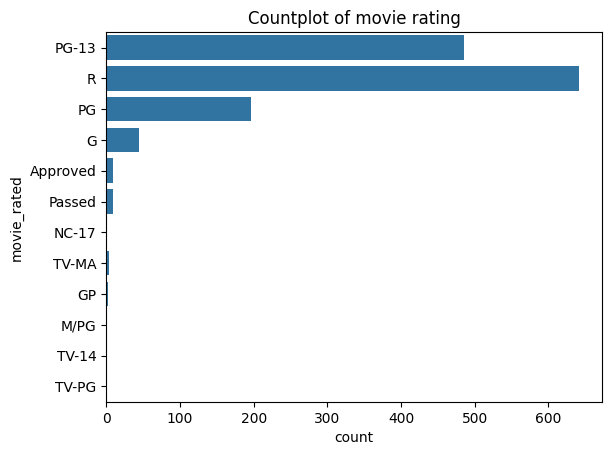

In [31]:
sns.countplot(y = df['movie_rated'])
plt.title('Countplot of movie rating')
plt.show()

In [32]:
def movie_rating(x):
    other = ['Approved', 'Passed', 'NC-17', 'TV-MA','GP', 'M/PG', 'TV-14', 'TV-PG']

    if x.strip() in other:
        return 'Other'
    else:
        return x

df['movie_rated'] = df['movie_rated'].apply(movie_rating)

In [33]:
df['movie_rated'].value_counts()

movie_rated
R        641
PG-13    485
PG       196
G         44
Other     27
Name: count, dtype: int64

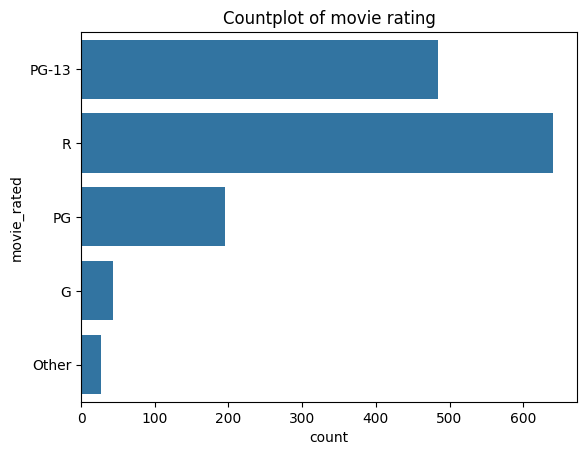

In [34]:
sns.countplot(y = df['movie_rated'])
plt.title('Countplot of movie rating')
plt.show()

In [35]:
#seperating genres
df['genres'] = df['genres'].apply(lambda x: x.split('; ')[:-1])

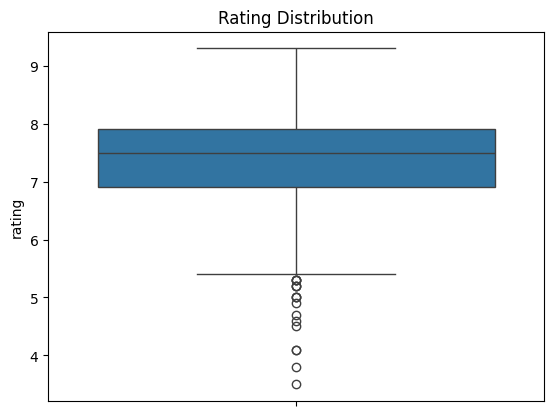

In [36]:

sns.boxplot(df['rating'])
plt.title("Rating Distribution")
plt.show()


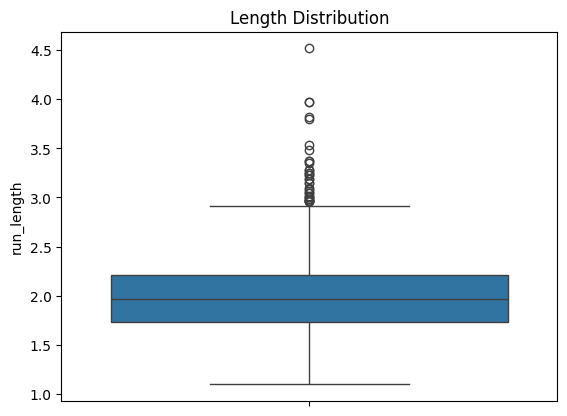

In [37]:
sns.boxplot(df['run_length'])
plt.title("Length Distribution")
plt.show()

In [38]:
'''
# 1. Combine all genres into a single list
all_genre = df['genres'].sum()  # This flattens the genres column into a list

# 2. Create a dictionary to count genre occurrences
genre_counts = {}
for genre in all_genre:
  if genre in genre_counts:
    genre_counts[genre] += 1  # Increment count if genre already exists
  else:
    genre_counts[genre] = 1  # Add genre with count 1 if new

# 3. Extract genre names and counts as separate lists
genre_names = list(genre_counts.keys())
genre_values = list(genre_counts.values())

# Rest of the code remains the same (using matplotlib and seaborn):

plt.figure(figsize=(15,5))
sns.barplot(x = genre_names, y = genre_values, palette = 'rocket')
plt.xticks(rotation = 45)
plt.title('Genres Count')
plt.show()
'''

"\n# 1. Combine all genres into a single list\nall_genre = df['genres'].sum()  # This flattens the genres column into a list\n\n# 2. Create a dictionary to count genre occurrences\ngenre_counts = {}\nfor genre in all_genre:\n  if genre in genre_counts:\n    genre_counts[genre] += 1  # Increment count if genre already exists\n  else:\n    genre_counts[genre] = 1  # Add genre with count 1 if new\n\n# 3. Extract genre names and counts as separate lists\ngenre_names = list(genre_counts.keys())\ngenre_values = list(genre_counts.values())\n\n# Rest of the code remains the same (using matplotlib and seaborn):\n\nplt.figure(figsize=(15,5))\nsns.barplot(x = genre_names, y = genre_values, palette = 'rocket')\nplt.xticks(rotation = 45)\nplt.title('Genres Count')\nplt.show()\n"

C:\Users\Jay Thoriya\AppData\Local\Temp\ipykernel_14544\4074720196.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = list(all_genre.keys()), y = list(all_genre.values()),palette = 'rocket')


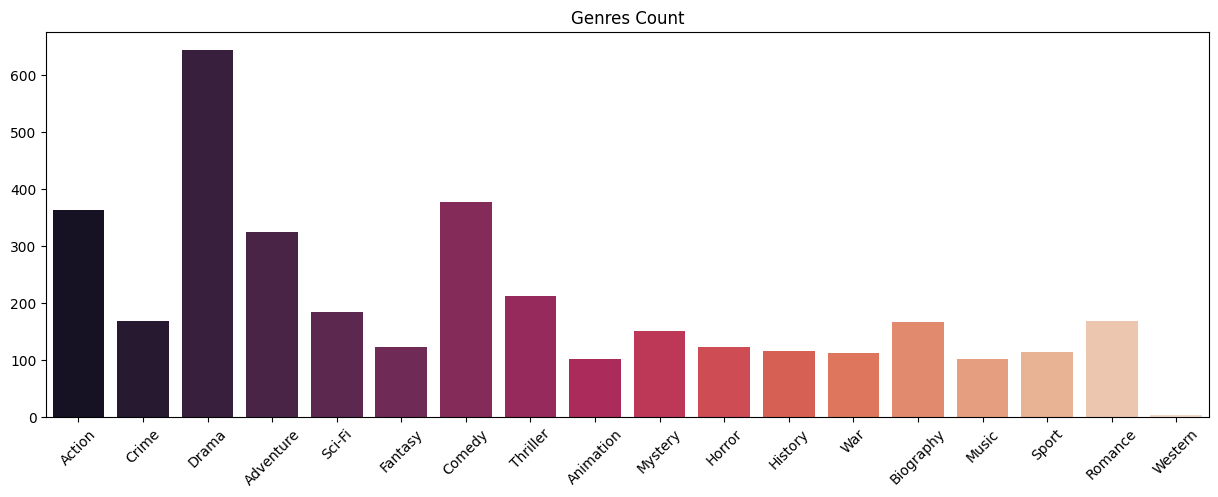

In [39]:

all_genre = sum(df['genres'],[])
all_genre = nltk.FreqDist(all_genre)
plt.figure(figsize=(15,5))
sns.barplot(x = list(all_genre.keys()), y = list(all_genre.values()),palette = 'rocket')
plt.xticks(rotation = 45)
plt.title('Genres Count')
plt.show()


In [40]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd

# Ensure you have the NLTK stopwords downloaded
nltk.download('stopwords')

def clean_text(text):
    # Compile regex patterns
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    
    # Apply regex substitutions
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    
    # Convert text to lower case
    text = text.lower()

    # Removing stopwords
    STOPWORDS = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in STOPWORDS]

    # Word lemmatization
    lemmatizer = PorterStemmer()
    sentence = [lemmatizer.stem(word) for word in text]

    return ' '.join(sentence)

# Assuming df is your DataFrame and 'review' is the column you want to clean
df['review'] = df['review'].apply(clean_text)
df.reset_index(drop=True, inplace=True)


[nltk_data] Downloading package stopwords to C:\Users\Jay
[nltk_data]     Thoriya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
df['review'] = df['review'].apply(clean_text)
df.reset_index(drop = True, inplace = True)

In [42]:
mb = MultiLabelBinarizer()
Y = mb.fit_transform(df['genres'])

In [43]:
X = df[['review']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 42, train_size = .8)

In [44]:
tfid = TfidfVectorizer(max_features= 10000)
tfid.fit(X_train['review'])
X_train_matrix = tfid.transform(X_train['review'])
X_test_matrix = tfid.transform(X_test['review'])

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
rf = RandomForestClassifier()
multi = OneVsRestClassifier(rf)
multi.fit(X_train_matrix, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier())

In [46]:
y_pred = multi.predict(X_test_matrix)

In [47]:
print("F1_score Training: ",f1_score(y_train, multi.predict(X_train_matrix), average = 'micro'))
print("F1_score Testing: ",f1_score(y_test, y_pred, average = 'micro'))

F1_score Training:  0.9803505045140732
F1_score Testing:  0.6382978723404256


In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.71      0.79        84
           1       0.72      0.46      0.56        68
           2       0.50      0.27      0.35        15
           3       1.00      0.12      0.21        34
           4       0.98      0.80      0.88        64
           5       0.75      0.28      0.41        32
           6       0.90      0.79      0.84       129
           7       0.50      0.10      0.17        30
           8       1.00      0.14      0.25        28
           9       0.94      0.57      0.71        28
          10       1.00      0.25      0.40        16
          11       0.92      0.38      0.54        29
          12       0.93      0.41      0.57        34
          13       0.81      0.38      0.52        45
          14       1.00      0.50      0.67        18
          15       0.92      0.33      0.49        36
          16       0.82      0.35      0.49        26
          17       0.00    

c:\Users\Jay Thoriya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jay Thoriya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Perfomace is ok. We can change the threshold value to 0.5 to 0.3 as it is a multiclass prediction

In [49]:
#changing the threshold value to 0.3 insteade of .5
y_pred_new = (multi.predict_proba(X_test_matrix) >= .3).astype(int)
print("F1_score with threshold 0.3: ",f1_score(y_test, y_pred_new, average = 'micro'))

F1_score with threshold 0.3:  0.7567213114754099


using XGBoosting

In [54]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

Making Pipeline 

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def pipe_line(classifier):
    text_preprocessor = TfidfVectorizer()
    preprocessor = ColumnTransformer([

        ('text1', text_preprocessor, 'review')
    ])
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    return pipeline


In [57]:
rf1= RandomForestClassifier()
classifier = OneVsRestClassifier(rf1)
model_rf = pipe_line(classifier)
model_xgb = pipe_line(xgb)

In [58]:
model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text1', TfidfVectorizer(),
                                                  'review')])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [59]:
y_pred_xgb = model_xgb.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

In [61]:
print("F1_score with RandomForest : ",f1_score(y_test, y_pred_rf, average = 'micro'))
print("F1_score with xgb : ",f1_score(y_test, y_pred_xgb, average = 'micro'))

F1_score with RandomForest :  0.5452812202097236
F1_score with xgb :  0.7657058388765706


: 

In [ ]:
df.head()

: 

: 

: 

: 

: 

: 

: 

: 

: 